In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install transformers sentence-transformers faiss-cpu pandas accelerate torch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.2 MB/s eta 0:00:00


In [4]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
pip install wordcloud -q

In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import os
import re
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, WeightedRandomSampler
from datasets import Dataset, DatasetDict
from transformers import DataCollatorWithPadding
from sklearn.metrics import classification_report
from torch import nn
import pickle

Update this path as per user folder structure

In [ ]:
transcript_folder = "/content/drive/MyDrive/transcripts/test/transcripts"

  cardiffnlp/twitter-roberta-base-sentiment" is a RoBERTa-based model, fine-tuned on Twitter sentiment analysis, making it highly effective for short, informal, and customer-like text.

  This model classifies three sentiments:
  Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive

In [7]:
# sentiment_model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_model_name = "cardiffnlp/twitter-roberta-base-sentiment"

In [8]:
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [9]:
# status_tokenizer = AutoTokenizer.from_pretrained(status_model_name)
# status_model = AutoModelForSequenceClassification.from_pretrained(status_model_name, num_labels=2)

**Zero-shot classification** allows a model to classify text into categories it was never explicitly trained on.

Traditional models require labeled training data, but zero-shot models use **Natural Language Inference (NLI)** to determine the most relevant category.

Instead of training a model from scratch, we provided a list of potential labels:

    candidate_labels = ["Issue Resolved", "Follow-up Needed"]


✅ Default Model Used in Zero-Shot Classification
👉 facebook/bart-large-mnli

🔹 Why BART?

BART (Bidirectional and Auto-Regressive Transformer) is designed for Natural Language Inference (NLI), making it ideal for zero-shot classification.

1. Trained on Multi-Label Natural Language Inference (MNLI)

2. Can classify text into unseen categories by treating labels as hypotheses

3. Doesn’t require labeled training data


🔹 Alternative Models for Zero-Shot Classification Model

  facebook/bart-large-mnli: Best general-purpose zero-shot classification model

  roberta-large-mnli: Slightly faster but less robust than BART

  deberta-v3-large-mnli: Newer model, often better on specific datasets

  t5-base: If we need text generation along with classification

In [10]:
# Initializing the models
sentiment_classifier = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=sentiment_tokenizer)
classifier_zero_shot = pipeline("zero-shot-classification")
candidate_labels = ["Issue Resolved", "Follow-up Needed"]

Device set to use cuda:0
No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [41]:
def analyze_text(text):
    """Analyze sentiment and determine if the issue is resolved or follow-up action is needed by dynamically selecting the last meaningful part of the conversation."""

    # Sentiment Analysis using Twitter RoBERTa
    sentiment_result = sentiment_classifier(text)[0]
    sentiment_label = sentiment_result['label']
    sentiment_score = sentiment_result['score']

    # Correct label mapping
    label_mapping = {"LABEL_0": "negative", "LABEL_1": "neutral", "LABEL_2": "positive"}
    sentiment = label_mapping[sentiment_label]

    # Splitting the conversation into sentences using regex to capture `.`, `!`, `?`
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())

    # Dynamically determine how many sentences to take from the end
    if len(sentences) <= 3:
        last_part = text
    else:
        last_part = " ".join(sentences[-min(5, len(sentences)):])

    # Use zero-shot classification to determine resolution status
    status_result = classifier_zero_shot(last_part, candidate_labels)

    # Getting the top prediction
    predicted_status = status_result['labels'][0]
    status_confidence = status_result['scores'][0]

    return sentiment, sentiment_score, predicted_status, status_confidence


In [49]:
import os
import re
import pandas as pd

results = []

for filename in os.listdir(transcript_folder):
    if filename.endswith(".txt"):  # Process only .txt files
        file_path = os.path.join(transcript_folder, filename)

        # Extracting all Member lines
        member_texts = []
        with open(file_path, "r", encoding="utf-8") as file:
            for line in file:
                match = re.match(r"Member:(.*)", line.strip(), re.IGNORECASE)
                if match:
                    member_texts.append(match.group(1).strip())


        if member_texts:
            full_member_text = " ".join(member_texts)
            sentiment, sentiment_score, status, status_confidence = analyze_text(full_member_text)  # Running sentiment & status analysis

            results.append({
                "File": filename,
                "Text": full_member_text,
                "Sentiment": sentiment,
                "Sentiment_Confidence": sentiment_score,
                "Outcome": status,
                "Outcome_Confidence": status_confidence
            })

transcript = pd.DataFrame(results)

In [50]:
# Sorting  by transcript number

transcript["Transcript_Number"] = transcript["File"].str.extract(r'(\d+)').astype(int)
transcript = transcript.sort_values(by="Transcript_Number").drop(columns=["Transcript_Number"])

In [51]:
transcript

,File,Text,Sentiment,Sentiment_Confidence,Outcome,Outcome_Confidence
0,transcript_0.txt,"Hi, I'm calling to get a case pre-authorized. ...",positive,0.849609,Follow-up Needed,0.782208
1,transcript_1.txt,"Hi, I'm calling about a denied claim I receive...",negative,0.667382,Follow-up Needed,0.705180
112,transcript_2.txt,"Hi, I'm calling about my recent doctor's visit...",positive,0.726456,Issue Resolved,0.811812
123,transcript_3.txt,"Hi, I'm calling about my recent visit to the d...",negative,0.894989,Follow-up Needed,0.823656
134,transcript_4.txt,"Hi, I'd like to schedule an appointment with a...",positive,0.935258,Follow-up Needed,0.576291
...,...,...,...,...,...,...
107,transcript_195.txt,"Hi, I'm calling about my online service accoun...",negative,0.440946,Issue Resolved,0.729628
108,transcript_196.txt,"Hi, I'm calling to schedule an appointment wit...",positive,0.950603,Issue Resolved,0.533961
109,transcript_197.txt,"Hi, I'm calling to get a case pre-authorized. ...",positive,0.669572,Issue Resolved,0.518153
110,transcript_198.txt,"Hi, I'm calling about my recent visit to the d...",positive,0.949513,Issue Resolved,0.649787


# Evaluating Labels

1. Interpretation of Confidence Score Distributions

2. Manual Review of Sampled Predictions -> We can take 20-30 randomly selected transcripts and check whether the sentiment and outcome matches actual human perception

3. Agreement Score (Inter-Annotator Agreement) -> Same model is annotating the data transcripts twice. We can use Cohen’s Kappa Score to measure the agreement.



1. Based on Confidence Scores

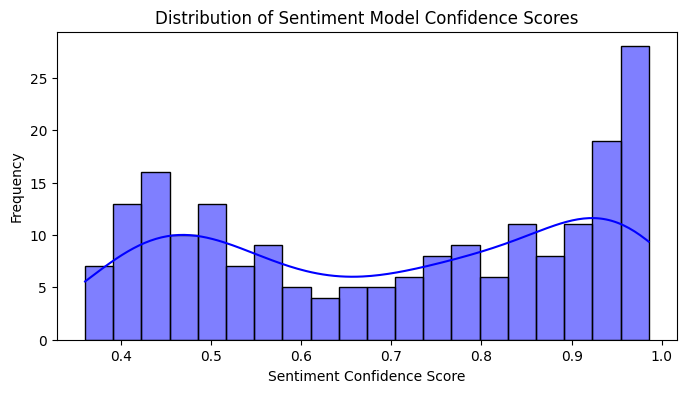

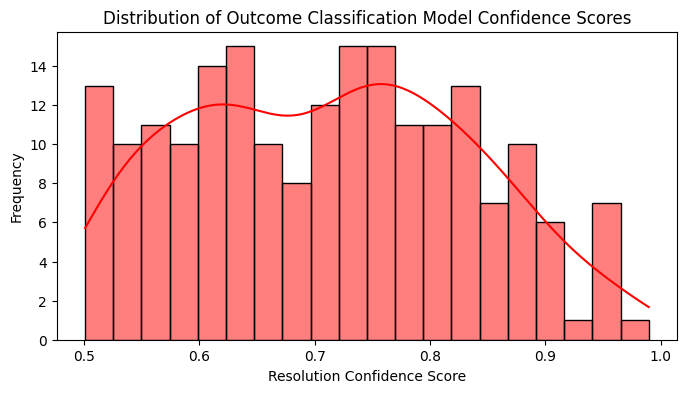

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confidence Score Distribution for Sentiment
plt.figure(figsize=(8, 4))
sns.histplot(transcript["Sentiment_Confidence"], bins=20, kde=True, color="blue")
plt.xlabel("Sentiment Confidence Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Model Confidence Scores")
plt.show()

# Plot Confidence Score Distribution for Issue Resolution
plt.figure(figsize=(8, 4))
sns.histplot(transcript["Outcome_Confidence"], bins=20, kde=True, color="red")
plt.xlabel("Resolution Confidence Score")
plt.ylabel("Frequency")
plt.title("Distribution of Outcome Classification Model Confidence Scores")
plt.show()

**Sentiment Confidence Score Distribution (Blue Chart)**

**Key Observation:** The confidence scores for sentiment analysis vary widely, with two peaks—one near 0.5 and another near 0.95-1.0.

**What This Means:**

1. High-confidence predictions suggest the model is very certain about many cases.

2. However, the presence of lower-confidence scores (~0.4-0.6) indicates uncertainty in some cases, possibly due to ambiguous language or mixed emotions.



**Outcome Classification Confidence Score Distribution (Red Chart)**

**Key Observation:** The distribution is more centered around 0.6-0.8, indicating moderate confidence across predictions.

**What This Means:**
1. The zero-shot classification model (BART) is relatively confident, but there’s still room for improvement.

2. Some cases have scores below 0.6, meaning the model might struggle to classify certain resolutions correctly.

In [34]:
results = []
file_count = 0  # Counter to limit to 10 files

for filename in os.listdir(transcript_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(transcript_folder, filename)

        # Extract and combine all Member lines
        member_texts = []
        with open(file_path, "r", encoding="utf-8") as file:
            for line in file:
                match = re.match(r"Member:(.*)", line.strip(), re.IGNORECASE)
                if match:
                    member_texts.append(match.group(1).strip())

        # If there are Member lines, analyze the combined text
        if member_texts:
            full_member_text = " ".join(member_texts)

            # **First Run of Analysis**
            sentiment_run1, status_run1 = analyze_text(full_member_text)

            # **Second Run of Analysis**
            sentiment_run2, status_run2 = analyze_text(full_member_text)

            # Append both runs
            results.append({
                "File": filename,
                "Text": full_member_text,
                "Sentiment_Run1": sentiment_run1,
                "Sentiment_Run2": sentiment_run2,  # Second run
                "Status_Run1": status_run1,
                "Status_Run2": status_run2  # Second run for outcome
            })

        file_count += 1  # Increment counter
        if file_count >= 200:
            break

evaluation = pd.DataFrame(results)

2. Cohen's Kappa

In [35]:
from sklearn.metrics import cohen_kappa_score

# Assuming you labeled the same dataset twice with the sentiment model
cohen_score_sentiment = cohen_kappa_score(evaluation["Sentiment_Run1"], evaluation["Sentiment_Run2"])
print(f"✅ Cohen's Kappa for Sentiment Model: {cohen_score_sentiment:.3f}")

✅ Cohen's Kappa for Sentiment Model: 1.000


Sentiment labels are stable across runs as Cohen's Kappa is 1.00

In [36]:
from sklearn.metrics import cohen_kappa_score

# Assuming you labeled the same dataset twice with the sentiment model
cohen_score_sentiment = cohen_kappa_score(evaluation["Status_Run1"], evaluation["Status_Run2"])
print(f"✅ Cohen's Kappa for Outcome Model: {cohen_score_sentiment:.3f}")

✅ Cohen's Kappa for Outcome Model: 1.000


In [39]:
# Compute sentiment-outcome distribution
evaluation.groupby(["Sentiment_Run1", "Status_Run1"]).size().unstack()

Status_Run1,Follow-up Needed,Issue Resolved
Sentiment_Run1,,
negative,3.0,NaN
neutral,NaN,1.0
positive,2.0,4.0


# Insights Analysis

In [ ]:
transcript

,File,Text,Sentiment,Status
0,transcript_0.txt,"Hi, I'm calling to get a case pre-authorized. ...",positive,Follow-up Needed
1,transcript_1.txt,"Hi, I'm calling about a denied claim I receive...",negative,Follow-up Needed
112,transcript_2.txt,"Hi, I'm calling about my recent doctor's visit...",positive,Issue Resolved
123,transcript_3.txt,"Hi, I'm calling about my recent visit to the d...",negative,Follow-up Needed
134,transcript_4.txt,"Hi, I'd like to schedule an appointment with a...",positive,Follow-up Needed
...,...,...,...,...
107,transcript_195.txt,"Hi, I'm calling about my online service accoun...",negative,Issue Resolved
108,transcript_196.txt,"Hi, I'm calling to schedule an appointment wit...",positive,Issue Resolved
109,transcript_197.txt,"Hi, I'm calling to get a case pre-authorized. ...",positive,Issue Resolved
110,transcript_198.txt,"Hi, I'm calling about my recent visit to the d...",positive,Issue Resolved


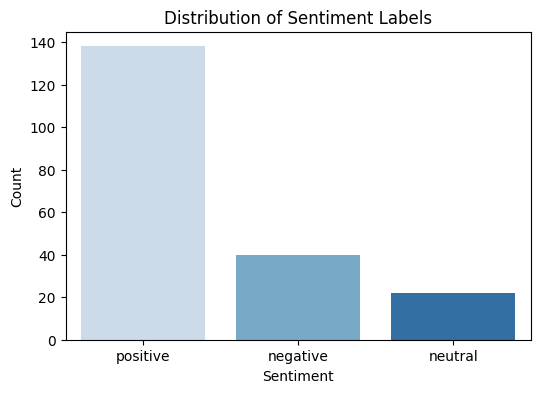

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=transcript["Sentiment"], palette="Blues", order=transcript["Sentiment"].value_counts().index)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Labels")
plt.show()



1.   Majority Positive Sentiment (≈ 140 cases)

    The dominance of positive sentiment suggests that most customer interactions have satisfactory or resolved outcomes.
    This could be a reflection of effective customer service, quick claim resolutions, or positive experiences.

2. Moderate Negative Sentiment (≈ 40 cases)

    A notable portion of interactions still express dissatisfaction.
    These could be delayed claims, policy disputes, denied coverage, or customer frustration with service speed.



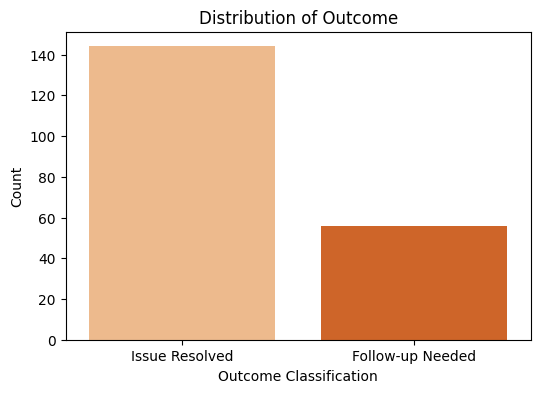

In [53]:
plt.figure(figsize=(6,4))
sns.countplot(x=transcript["Outcome"], palette="Oranges", order=transcript["Outcome"].value_counts().index)
plt.xlabel("Outcome Classification")
plt.ylabel("Count")
plt.title("Distribution of Outcome")
plt.show()

  The high proportion of "Issue Resolved" cases suggests that the customer support is effectively addressing most concerns.

  This aligns with the high positive sentiment observed in the previous graph, indicating that many customers are satisfied with the resolution process.

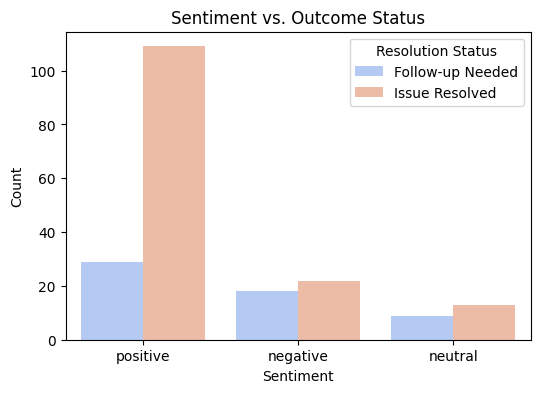

In [54]:
plt.figure(figsize=(6,4))
sns.countplot(x=transcript["Sentiment"], hue=transcript["Outcome"], palette="coolwarm")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment vs. Outcome Status")
plt.legend(title="Resolution Status")
plt.show()

1. The majority of positive sentiment cases are in the "Issue Resolved" category.
    This aligns well with expectations—customers express positivity when their concerns are addressed.

2. A smaller but noticeable number of cases with positive sentiment remain in "Follow-up Needed".
    This may indicate:
    Customers expressing gratitude even if their issue is still open (e.g., "Thank you, I appreciate the help, but my issue isn’t fully resolved yet.")

3. Some negative sentiment cases are marked as "Issue Resolved".
    Possible Reason can be:
    Frustration with the resolution process, even if the issue is marked as resolved


Extract Important Words

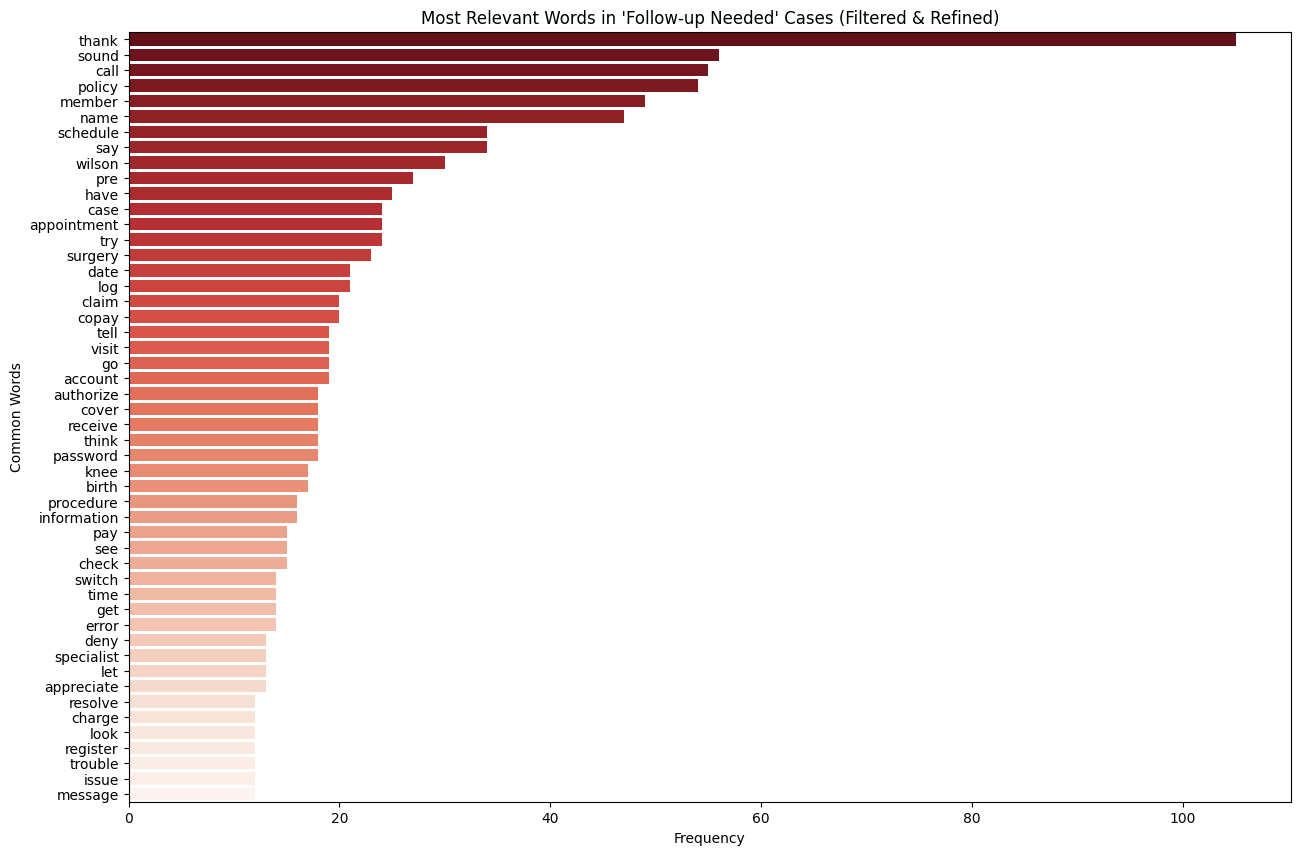

In [55]:
import spacy
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define a custom stopword list (remove common vague words)
custom_stopwords = set([
    "get", "have", "need", "do", "say", "try", "take", "cover", "pause", "number",
    "sound", "okay", "help", "service", "Wilson", "doctor"
])

# Filter only "Follow-up Needed" cases
unresolved_text = " ".join(transcript[transcript["Outcome"] == "Follow-up Needed"]["Text"]).lower()

# Process text with spaCy
doc = nlp(unresolved_text)

# Extract only meaningful words (nouns & verbs), remove stopwords
filtered_words = [
    token.lemma_ for token in doc
    if token.is_alpha and token.text.lower() not in custom_stopwords and token.pos_ in {"NOUN", "VERB"}
]

# Count most frequent meaningful words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(50)  # Get top 20 most frequent words

common_df = pd.DataFrame(common_words, columns=["Word", "Frequency"])

plt.figure(figsize=(15,10))
sns.barplot(x=common_df["Frequency"], y=common_df["Word"], palette="Reds_r")
plt.xlabel("Frequency")
plt.ylabel("Common Words")
plt.title("Most Relevant Words in 'Follow-up Needed' Cases (Filtered & Refined)")
plt.show()


1. **Insurance-Specific Terms Are Prominent**

    "Policy," "Claim," "Copay," "Coverage," "Authorize" → These are directly related to insurance claims, billing, and approvals.
    This confirms that many follow-up cases are linked to claims, eligibility, or payment disputes.

2. **Health & Medical Terms Appear in Follow-up Cases**

    "Surgery," "Procedure," "Specialist," "Appointment," "Birth," "Knee" → These indicate that many unresolved cases involve medical claims, scheduling, and approvals.

3. **Technical & Account Issues Are Common**

    "Password," "Account," "Register," "Log," "Switch" → These suggest that some follow-up cases are due to login, security, or registration issues.

    Not all follow-up cases are claims-related—some are digital access issues.

Extract Key Entities Using Named Entity Recognition (NER)

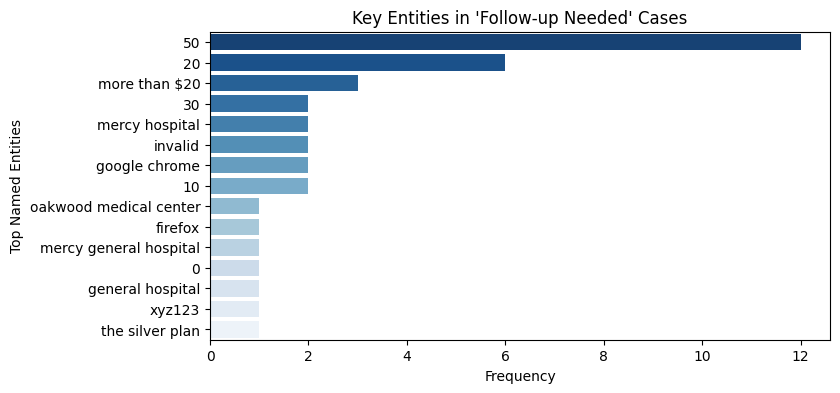

In [56]:
import spacy
from collections import Counter

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Process unresolved cases
unresolved_text = " ".join(transcript[transcript["Outcome"] == "Follow-up Needed"]["Text"])
doc = nlp(unresolved_text)

# Extract Named Entities (only relevant types)
entity_labels = ["ORG", "MONEY", "PRODUCT", "EVENT", "LAW"]
entities = [ent.text.lower() for ent in doc.ents if ent.label_ in entity_labels]

# Count most frequent entities
entity_counts = Counter(entities).most_common(15)

entity_df = pd.DataFrame(entity_counts, columns=["Entity", "Frequency"])

plt.figure(figsize=(8,4))
sns.barplot(x=entity_df["Frequency"], y=entity_df["Entity"], palette="Blues_r")
plt.xlabel("Frequency")
plt.ylabel("Top Named Entities")
plt.title("Key Entities in 'Follow-up Needed' Cases")
plt.show()


1. **Frequent Mentions of Dollar Amounts ("50", "20", "more than $20")**

    The most common named entities relate to monetary amounts, indicating many follow-up cases involve billing disputes, claim amounts, or unexpected charges.

2. **Multiple Hospital & Medical References ("Mercy Hospital", "Oakwood Medical Center", "General Hospital")**

    Health insurance claims & medical billing are a major source of follow-ups.
  
    Hospitals being frequently mentioned suggests customers are contacting regarding medical claim approvals, denied procedures, or hospital billing issues.

3. **Technical Terms ("Google Chrome", "Firefox", "Invalid") Appear in Follow-up Cases**

    Mentions of browsers suggest digital or login-related issues, possibly affecting online account access.

    The word "invalid" might relate to invalid credentials, denied claims, or system errors preventing account access.

4. **Insurance Plan Mentions ("The Silver Plan")**

    Specific plan names appearing in follow-ups could mean certain  insurance products have higher customer concerns.




Extraction of true emotional insights from follow-up cases

In [57]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Filter only "Follow-up Needed" cases
unresolved_text = " ".join(transcript[transcript["Outcome"] == "Follow-up Needed"]["Text"])

# Process text with spaCy
doc = nlp(unresolved_text)

# Extract adjectives (ADJ) and adverbs (ADV)
emotion_words = [token.text.lower() for token in doc if token.pos_ in {"ADJ", "ADV"}]

# Count most frequent emotional words
emotion_counts = Counter(emotion_words).most_common(25)

emotion_df = pd.DataFrame(emotion_counts, columns=["Word", "Frequency"])

Emotion Related Word Cloud

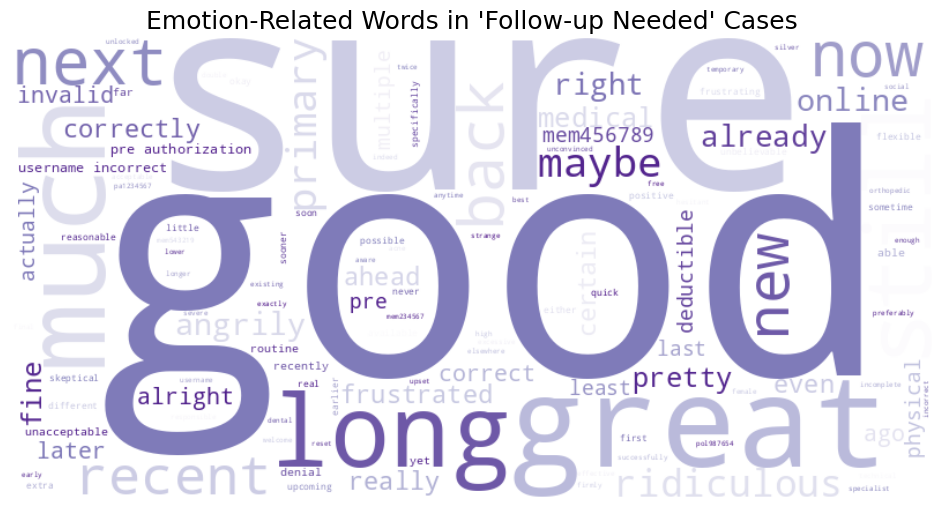

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Creating word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Purples").generate(" ".join(emotion_words))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Emotion-Related Words in 'Follow-up Needed' Cases", fontsize=18)
plt.show()


1. **Unexpectedly Positive Words ("Good", "Great", "Sure") Appear in Follow-up Cases**

2. **Frustration Indicators Exist but Are Less Dominant ("Frustrated", "Ridiculous", "Upset")**

    Possible explanation: Customers might avoid aggressive language in formal insurance queries, making it harder for models to detect genuine frustration.

3. **Timing & Urgency Words Appear ("Now", "Next", "Still", "Later", "Recent")**

    Customers are concerned with delays, next steps, or how long a case remains unresolved.
  
    This suggests that many follow-up cases are due to pending approvals, slow responses, or missing updates.

Word Cloud as per Outcome - Issue Resolved and Follow-up Needed

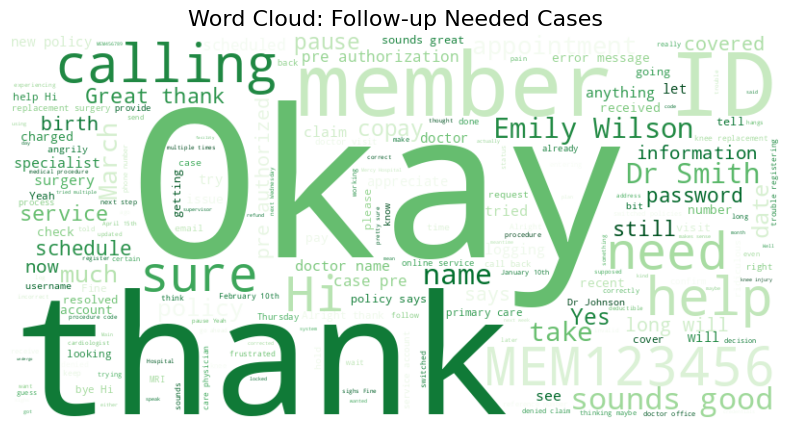

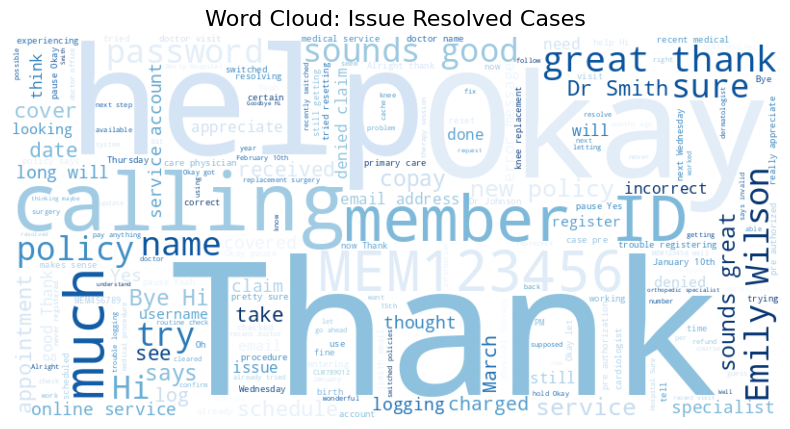

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define a function to generate word clouds
def generate_wordcloud(text_data, title, colormap="Purples"):
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap=colormap).generate(" ".join(text_data))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Filter text data for different cases
follow_up_text = transcript[transcript["Outcome"] == "Follow-up Needed"]["Text"]
resolved_text = transcript[transcript["Outcome"] == "Issue Resolved"]["Text"]

generate_wordcloud(follow_up_text, "Word Cloud: Follow-up Needed Cases", colormap="Greens")
generate_wordcloud(resolved_text, "Word Cloud: Issue Resolved Cases", colormap="Blues")

Analyzing the Negative Sentiment

In [ ]:
# Filter negative sentiment cases
negative_reviews = transcript[transcript["Sentiment"].str.lower() == "negative"]["Text"].dropna()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Custom tokenizer to preserve contractions like "I've"
def custom_tokenizer(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s']", "", text)  # Keep contractions like "I've"
    return text.split()

# Use TfidfVectorizer with custom tokenizer
vectorizer = TfidfVectorizer(ngram_range=(2,3), stop_words="english", tokenizer=custom_tokenizer)
X_neg = vectorizer.fit_transform(negative_reviews)

# Get phrase frequencies
phrase_counts_neg = X_neg.sum(axis=0)
phrases_neg = vectorizer.get_feature_names_out()
phrase_freq_neg = [(phrases_neg[i], phrase_counts_neg[0, i]) for i in range(len(phrases_neg))]

# Sort and remove noise dynamically
phrase_freq_neg = sorted(phrase_freq_neg, key=lambda x: x[1], reverse=True)


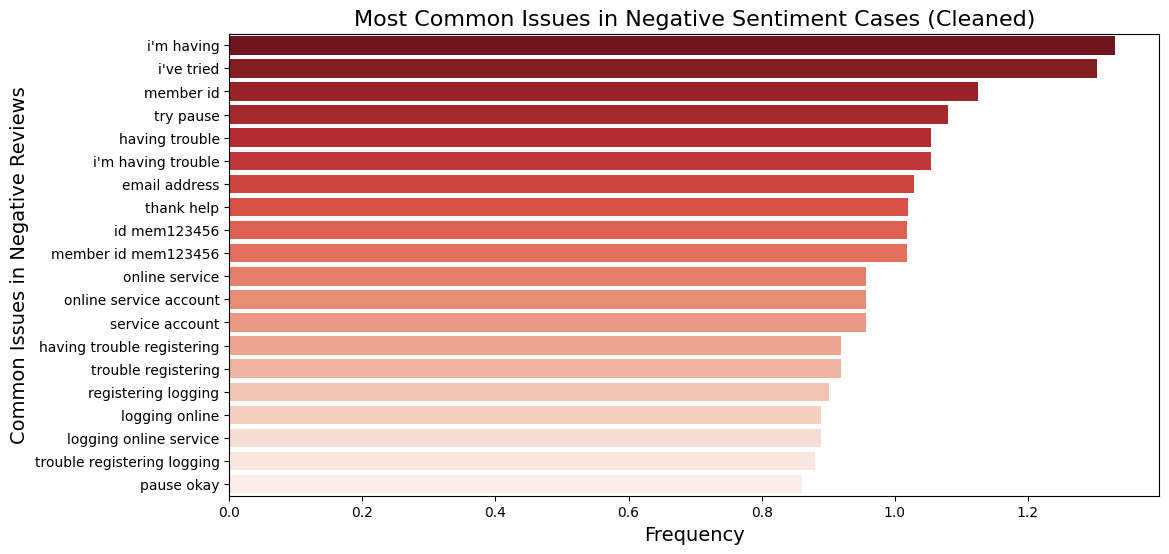

In [ ]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")

# Process words with spaCy
filtered_phrases = []
for phrase, freq in phrase_freq_neg:
    words = phrase.split()
    doc = nlp(" ".join(words))

    # Keeping only phrases that contain at least one noun or verb
    if any(token.pos_ in {"NOUN", "VERB"} for token in doc):
        filtered_phrases.append((phrase, freq))


phrase_neg_df = pd.DataFrame(filtered_phrases[:20], columns=['Phrase', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(x=phrase_neg_df["Frequency"], y=phrase_neg_df["Phrase"], palette="Reds_r")
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Common Issues in Negative Reviews", fontsize=14)
plt.title("Most Common Issues in Negative Sentiment Cases (Cleaned)", fontsize=16)
plt.show()


1. **High Frequency of "I'm Having" and "I've Tried" Indicates Ongoing Struggles**

    The top issues include phrases like "I'm having" and "I've tried," suggesting that customers are repeatedly facing difficulties despite attempting solutions.

2. **Account & Login Issues Are Major Sources of Negative Sentiment**

    "Email address," "Online service," "Logging online," "Trouble registering" indicate that many negative cases stem from customers struggling with account access.

3. **Frequent Mentions of "Member ID" Suggest Identity Verification Challenges**

    Terms like "Member ID," "ID mem123456" appearing frequently indicate that users often need to verify their identity or retrieve account information.

# Future Approach

1️. **Fine-Tuning RoBERTa for Sentiment & Outcome Prediction**

Currently, we are fine-tuning two models:

1. RoBERTa-Base for Sentiment Analysis

2. RoBERTa-Large for Call Outcome Classification

How it works:

1. The training pipeline splits the data into train (90%) and test (10%).
2. The models learn using class-weighted sampling to handle imbalanced  data.
3. Tokenization & preprocessing ensure high-quality inputs for training.
4. The models are trained for four epochs with early stopping to avoid overfitting.
5. Best models are saved for future inference to ensure performance consistency.

**Why RoBERTa?**

1. Stronger contextual understanding than vanilla BERT.
2. Handles complex customer interactions effectively in insurance-based conversations.
3. Larger model (RoBERTa-Large) for call outcome ensures high classification accuracy


2️. **FAISS for Vector Storage & Continuous Learning**

Proposed Approach Using FAISS:

1. Store initially labeled data as dense embeddings in FAISS (Facebook AI Similarity Search).

2. As new customer interactions arrive, we'll embed them and search for similar cases in FAISS to see if they can be classified without model inference.

3. Once every 100 new entries, the FAISS system automatically triggers model fine-tuning with the new data.

4. Over time, the model continuously improves, requiring less reliance on FAISS for classification.

Key Benefits:

1. Faster inference since similar cases are retrieved from FAISS instead of running inference on every query.

2. Reduces dependence on retraining from scratch → The model gradually improves without needing full dataset re-processing.

3. Creates a highly adaptive system that learns from new data without human intervention.


3️. **Long-Term Vision: Reaching Near Human-Level Classification**


1. Initially, FAISS assists in retrieving previously labeled interactions to reduce model inference load.

2. As the model gets more fine-tuned with every iteration, the need
for FAISS decreases.

3. At a certain point, the model will be so robust that it won’t even require FAISS retrieval—it will generalize across customer queries with high accuracy.

FAISS integration

In [19]:
from sentence_transformers import SentenceTransformer
import faiss
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
vector_dim = 384  # MiniLM embeddings have 384 dimensions
vector_db = faiss.IndexFlatL2(vector_dim)
metadata_store = {}
metadata_id = 0

In [22]:
def get_embeddings(text):
    """Generates embeddings using all-MiniLM-L6-v2."""
    return embedding_model.encode([text])[0]

In [20]:
def store_in_vector_db(customer_text, sentiment, call_outcome):
    """Stores transcript embeddings in FAISS."""
    global metadata_id
    embedding = get_embeddings(customer_text)
    vector_db.add(embedding.reshape(1, -1))
    metadata_store[metadata_id] = {
        "customer_text": customer_text,
        "sentiment": sentiment,
        "call_outcome": call_outcome
    }
    metadata_id += 1

Adding this after labelling has been done and data is prepared. After every .txt file is processed, this will be triggered and the transcript will be added in the DB. Below is the code, with faiss integration

In [ ]:
transcript_folder = "/content/drive/MyDrive/transcripts/test/transcripts"

results = []

for filename in os.listdir(transcript_folder):
    if filename.endswith(".txt"):  # Process only .txt files
        file_path = os.path.join(transcript_folder, filename)

        # Extracting all Member lines
        member_texts = []
        with open(file_path, "r", encoding="utf-8") as file:
            for line in file:
                match = re.match(r"Member:(.*)", line.strip(), re.IGNORECASE)
                if match:
                    member_texts.append(match.group(1).strip())


        if member_texts:
            full_member_text = " ".join(member_texts)
            sentiment, status = analyze_text(full_member_text)  # Running sentiment & status analysis

            store_in_vector_db(full_member_text, sentiment, status) # Storing the results in faiss db after extracting the sentiment and outcome

            results.append({
                "File": filename,
                "Text": full_member_text,
                "Sentiment": sentiment,
                "Outcome": Outcome
            })

transcript = pd.DataFrame(results)

Loading data from faiss

In [25]:
def load_labeled_data():
    """Loads labeled sentiment & outcome data from FAISS."""
    global metadata_store
    data = []
    for idx in metadata_store:
        entry = metadata_store[idx]
        data.append({
            "Customer Text": entry["customer_text"],
            "Sentiment": entry["sentiment"],
            "Call Outcome": entry["call_outcome"]
        })
    return pd.DataFrame(data)

df = load_labeled_data()
print(f"✅ Loaded {len(df)} labeled records.")

✅ Loaded 200 labeled records.


Modelling: Fine Tuning

In [32]:
# Split into train/test
train_data, test_data = train_test_split(transcript, test_size=0.1, random_state=10)

# Initialize Tokenizers
sentiment_model_name = "roberta-base"
outcome_model_name = "roberta-large"
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
outcome_tokenizer = AutoTokenizer.from_pretrained(outcome_model_name)

# Label Encoding
sentiment_encoder = LabelEncoder()
train_data["Sentiment_Label"] = sentiment_encoder.fit_transform(train_data["Sentiment"])
test_data["Sentiment_Label"] = sentiment_encoder.transform(test_data["Sentiment"])

outcome_encoder = LabelEncoder()
train_data["Call_Outcome_Label"] = outcome_encoder.fit_transform(train_data["Outcome"])
test_data["Call_Outcome_Label"] = outcome_encoder.transform(test_data["Outcome"])

# Compute Class Weights
def compute_class_weights(labels):
    class_counts = labels.value_counts().sort_index()
    total_samples = sum(class_counts)
    class_weights = {cls: total_samples/count for cls, count in class_counts.items()}
    return labels.map(class_weights)

# Compute Weights
sentiment_weights = compute_class_weights(train_data["Sentiment_Label"])
outcome_weights = compute_class_weights(train_data["Call_Outcome_Label"])

# Weighted Sampler
sentiment_sampler = WeightedRandomSampler(weights=sentiment_weights.values, num_samples=len(sentiment_weights), replacement=True)
outcome_sampler = WeightedRandomSampler(weights=outcome_weights.values, num_samples=len(outcome_weights), replacement=True)

# Preprocessing Functions
def preprocess_function_sentiment(examples):
    tokenized_inputs = sentiment_tokenizer(examples["Text"], padding="max_length", truncation=True)
    tokenized_inputs["labels"] = [examples["Label"]]  # Ensure label is a list
    return tokenized_inputs

def preprocess_function_outcome(examples):
    tokenized_inputs = outcome_tokenizer(examples["Text"], padding="max_length", truncation=True)
    tokenized_inputs["labels"] = [examples["Label"]]  # Ensure label is a list
    return tokenized_inputs

# Convert DataFrames to Dataset
train_dataset_sentiment = Dataset.from_pandas(train_data.rename(columns={"Sentiment_Label": "Label"})).map(preprocess_function_sentiment)
test_dataset_sentiment = Dataset.from_pandas(test_data.rename(columns={"Sentiment_Label": "Label"})).map(preprocess_function_sentiment)

train_dataset_outcome = Dataset.from_pandas(train_data.rename(columns={"Call_Outcome_Label": "Label"})).map(preprocess_function_outcome)
test_dataset_outcome = Dataset.from_pandas(test_data.rename(columns={"Call_Outcome_Label": "Label"})).map(preprocess_function_outcome)

# Load Models
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name, num_labels=len(sentiment_encoder.classes_))
outcome_model = AutoModelForSequenceClassification.from_pretrained(outcome_model_name, num_labels=len(outcome_encoder.classes_))

# Data Collator
data_collator = DataCollatorWithPadding(tokenizer=sentiment_tokenizer)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./roberta_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"
)

# Train Sentiment Model
trainer_sentiment = Trainer(
    model=sentiment_model,
    args=training_args,
    train_dataset=train_dataset_sentiment,
    eval_dataset=test_dataset_sentiment,
    data_collator=data_collator
)
print("🚀 Training Sentiment Model...")
trainer_sentiment.train()

# Train Outcome Model
trainer_outcome = Trainer(
    model=outcome_model,
    args=training_args,
    train_dataset=train_dataset_outcome,
    eval_dataset=test_dataset_outcome,
    data_collator=data_collator
)
print("🚀 Training Outcome Model...")
trainer_outcome.train()

# Save Best Models
best_sentiment_model_path = "./best_sentiment_model.pkl"
best_outcome_model_path = "./best_outcome_model.pkl"

with open(best_sentiment_model_path, "wb") as f:
    pickle.dump(sentiment_model, f)

with open(best_outcome_model_path, "wb") as f:
    pickle.dump(outcome_model, f)

print("✅ Best models saved successfully!")

# Evaluation Function
def evaluate_predictions(model, tokenizer, test_data, encoder):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_encodings = tokenizer(list(test_data["Text"]), padding=True, truncation=True, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**test_encodings)

    preds = torch.argmax(outputs.logits, axis=1).cpu().numpy()
    y_true = test_data.iloc[:, 1].values

    print(classification_report(y_true, preds, target_names=encoder.classes_))


Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Training Sentiment Model...


Epoch,Training Loss,Validation Loss
1,0.799100,0.608879
2,0.759600,0.427808
3,0.536500,0.341732
4,0.382300,0.362580


🚀 Training Outcome Model...


Epoch,Training Loss,Validation Loss
1,0.607300,0.607390
2,0.601000,0.812526
3,0.713200,0.383144
4,0.429600,0.322933


✅ Best models saved successfully!


In [33]:
# Evaluate Models
print("\n📊 Sentiment Model Evaluation:")
evaluate_predictions(sentiment_model, sentiment_tokenizer, test_data[["Text", "Sentiment_Label"]], sentiment_encoder)

print("\n📊 Call Outcome Model Evaluation:")
evaluate_predictions(outcome_model, outcome_tokenizer, test_data[["Text", "Call_Outcome_Label"]], outcome_encoder)


📊 Sentiment Model Evaluation:
              precision    recall  f1-score   support

    negative       0.80      1.00      0.89         4
     neutral       0.00      0.00      0.00         2
    positive       0.93      1.00      0.97        14

    accuracy                           0.90        20
   macro avg       0.58      0.67      0.62        20
weighted avg       0.81      0.90      0.85        20


📊 Call Outcome Model Evaluation:
                  precision    recall  f1-score   support

Follow-up Needed       1.00      0.50      0.67         6
  Issue Resolved       0.82      1.00      0.90        14

        accuracy                           0.85        20
       macro avg       0.91      0.75      0.78        20
    weighted avg       0.88      0.85      0.83        20

